# Evaluation of Time-Series Models


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
import altair as alt


## Evaluation Metrics

*This section provides a detailed overview of various metrics used to quantify the performance of time-series forecasting models. Metrics are categorized based on their properties (scale-dependence, percentage-based, weighted, and scaled) to help understand their applicability and limitations. For each metric, we will discuss its formula, interpretation*

*Notation:*
*   \\( y_i \\): Actual (true) value at time step \\( i \\)
*   \\( \hat{y}_i \\): Forecasted (predicted) value at time step \\( i \\)
*   \\( e_i = y_i - \hat{y}_i \\): Forecast error at time step \\( i \\)
*   \\( n \\): Number of observations in the evaluation period.

In [ ]:
# Using the simple arrays for clarity for all evaluation Metrics
true_values = np.array([105, 110, 112, 120, 118, 125, 130, 128, 135, 140])
predicted_values = np.array([108, 107, 115, 122, 116, 123, 135, 125, 138, 139])

days_of_week_numeric = np.array([0, 1, 2, 3, 4, 5, 6, 0, 1, 2]) # Mon-Sun, then Mon-Wed

train_values = np.array([100, 102, 104, 101, 103, 105]) # Values preceding our test set

### Scale-Dependent Metrics

These metrics measure forecast errors in the **same scale as the original data**, which makes them highly intuitive. For example, if you are forecasting the **number of cars sold**, the error from these metrics will also be in 'number of cars'.


#### Mean Absolute Error (MAE)
> $$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| = \frac{1}{n} \sum_{i=1}^{n} |e_i| $$

**Interpretation:**
MAE tells you the average magnitude of the forecast error. If the MAE is 5, it means that, on average, the forecast is off by 5 units (e.g., "5 cars sold"), regardless of whether the forecast was too high or too low.



#### Mean Squared Error (MSE) & Root Mean Squared Error (RMSE)
> $$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum_{i=1}^{n} e_i^2 $$

> $$ \text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

**Interpretation (MSE):**
MSE is not very intuitive on its own because the errors are squared, resulting in squared units (e.g., "squared cars"). Its primary purpose is as an intermediate step for calculating RMSE and as a common loss function for training models, because it **heavily penalizes larger errors**. An error of 10 becomes 100 in the MSE calculation, while an error of 2 only becomes 4.

**Interpretation (RMSE):**
RMSE is the square root of the MSE, which conveniently converts the error metric back into the **same scale as the original data** (e.g., 'cars sold'). Like MAE, a lower RMSE is better.

> Note : Why **"same scale, not units"** ?

- While both are in the same units, MAE represents the true average error, whereas RMSE penalizes large errors more heavily due to the squaring process, making it a measure of the typical error magnitude where outliers have a greater impact.

In [ ]:
# Calculate metrics
mae = mean_absolute_error(true_values, predicted_values)
mse = mean_squared_error(true_values, predicted_values)
rmse = np.sqrt(mse)

print("--- Calculated Metrics on Simple Data ---")
print(f"Mean Absolute Error (MAE):   {mae:.2f}")
print(f"Mean Squared Error (MSE):    {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

--- Calculated Metrics on Simple Data ---
Mean Absolute Error (MAE):   2.70
Mean Squared Error (MSE):    8.30
Root Mean Squared Error (RMSE): 2.88


#### Visualizing Errors
Metrics give you a single number summary, but visualizing the forecasts against the actual values helps understand where the model is performing poorly.

In [ ]:
plot_df = pd.DataFrame({
    'Time Step': np.arange(len(true_values)),
    'Actual': true_values,
    'Predicted': predicted_values
}).melt(id_vars='Time Step', var_name='Type', value_name='Value')

In [ ]:
error_df = pd.DataFrame({
    'Time Step': np.arange(len(true_values)),
    'Error': predicted_values - true_values
})
error_df['Error Type'] = np.where(error_df['Error'] >= 0, 'Over-predicted', 'Under-predicted')

highlight = alt.selection_point(on='mouseover', fields=['Time Step'], nearest=True, empty='none')


# LEFT PLOT: Actual vs. Predicted (now with size properties)
actual_vs_pred_plot = alt.Chart(plot_df).mark_line(point=True).encode(
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Value:Q', title='Quantity Sold'),
    color=alt.Color('Type:N',
        scale=alt.Scale(domain=['Actual', 'Predicted'], range=['#4C72B0', '#DD8452']),
        legend=alt.Legend(title='Forecast vs. Actual', symbolType='stroke')
    ),
    strokeDash=alt.condition(alt.datum.Type == 'Predicted', alt.value([5, 5]), alt.value([0])),
    tooltip=['Time Step', 'Type', 'Value'],
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350,  # Make this subplot wider
    height=300, # and taller
    title='Forecast vs. Actual'
).add_params(
    highlight
)

# RIGHT PLOT: Forecast Errors (now with size properties)
error_plot = alt.Chart(error_df).mark_bar().encode(
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Error:Q', title='Forecast Error (Predicted - Actual)'),
    color=alt.Color('Error Type:N',
        scale=alt.Scale(domain=['Over-predicted', 'Under-predicted'], range=['#DD8452', '#55A868']),
        # Give this legend its own clear title
        legend=alt.Legend(title='Error Breakdown')
    ),
    tooltip=['Time Step', 'Error'],
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=300,  # Make this subplot wider
    height=300, # and taller
    title='Forecast Error'
).add_params(
    highlight
)

zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='black', strokeWidth=0.5).encode(y='y')


# --- 4. Combine with Improved Legend Handling ---
final_dashboard = (actual_vs_pred_plot | (error_plot + zero_line)).properties(
    title=alt.TitleParams(
        "Interactive Model Performance Dashboard",
        subtitle="Hover over a point on one chart to highlight the corresponding data on the other.",
        fontSize=18, subtitleFontSize=13
    )
).resolve_legend(
    color = 'independent'
)

final_dashboard

alt.HConcatChart(...)

This interactive dashboard pairs the **Forecast vs. Actual** plot with a corresponding **Forecast Error** bar chart. The two plots are linked, allowing a user to hover over any time step to highlight and instantly connect a specific forecast to the magnitude and direction of its error.

### Percentage-Based Metrics

These metrics are scale-independent because they express error as a percentage. This makes them useful for comparing forecast accuracy across time series with different scales (e.g., comparing the forecast for a product that sells 100 units/day vs. one that sells 10,000 units/day). However, they have their own limitations, especially when dealing with zero or near-zero actual values.


#### Mean Absolute Percentage Error (MAPE)

> $$ \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\% $$


MAPE represents the average absolute percentage difference between predicted and actual values. A lower MAPE indicates better accuracy. Its main drawback is that it produces infinite or undefined values when the actual value \\(y_i\\) is zero and can be skewed if values are close to zero.

In [ ]:
y_true_safe = true_values
y_pred_safe = predicted_values

# Calculate MAPE
mape = np.mean(np.abs((y_true_safe - y_pred_safe) / y_true_safe)) * 100

print(f"Mean Absolute Percentage Error (MAPE):   {mape:.2f}%")

Mean Absolute Percentage Error (MAPE):   2.24%


#### Symmetric Mean Absolute Percentage Error (sMAPE)

It addresses some of the limitations of MAPE, particularly its asymmetry and issues with zero values. We will use the common variation that ranges from 0% to 200%.

> $$ \text{sMAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2} \times 100\% $$


sMAPE is a percentage error that attempts to be symmetric by including both the actual and predicted values in the denominator. A value closer to 0% indicates better performance.

In [ ]:
# Calculate sMAPE
# Denominator adds both values, so it's safer, but we still use the safe arrays for consistency
smape = np.mean(2 * np.abs(y_true_safe - y_pred_safe) / (np.abs(y_true_safe) + np.abs(y_pred_safe))) * 100

print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%")

Symmetric Mean Absolute Percentage Error (sMAPE): 2.23%


#### Visualizing Errors
Metrics give you a single number summary, but visualizing the forecasts against the actual values helps understand where the model is performing poorly.

In [ ]:
# Visualization of Percentage Errors
#The left plot provides the context of the forecast,
#while the right plot visualizes the Absolute Percentage Error for each individual time step.

# DataFrame for the Percentage Error plot
pct_error_df = pd.DataFrame({
    'Time Step': np.arange(len(true_values)),
    'Absolute Percentage Error': np.abs((true_values - predicted_values) / true_values) * 100
})

highlight = alt.selection_point(on='mouseover', fields=['Time Step'], nearest=True, empty='none')

# LEFT PLOT: Context (Forecast vs. Actual)
actual_vs_pred_plot = alt.Chart(plot_df).mark_line(point=True).encode(
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Value:Q', title='Quantity Sold'),
    color=alt.Color('Type:N',
        scale=alt.Scale(domain=['Actual', 'Predicted'], range=['#4C72B0', '#DD8452']),
        legend=alt.Legend(title='Forecast vs. Actual')
    ),
    strokeDash=alt.condition(alt.datum.Type == 'Predicted', alt.value([5, 5]), alt.value([0])),
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350, height=300,
    title='Forecast vs. Actual (Context)'
).add_params(highlight)

# RIGHT PLOT: Absolute Percentage Errors
pct_error_plot = alt.Chart(pct_error_df).mark_bar(color='#9467bd').encode( # Using a purple color for percentage
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Absolute Percentage Error:Q', title='Absolute Percentage Error (%)'),
    tooltip=['Time Step', alt.Tooltip('Absolute Percentage Error:Q', format='.2f')],
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350, height=300,
    title='Individual Percentage Errors'
).add_params(highlight)

# --- Combine the Plots Horizontally ---
percentage_dashboard = (actual_vs_pred_plot | pct_error_plot).properties(
    title=alt.TitleParams(
        "Interactive Dashboard for Percentage Errors",
        subtitle="Hover over a chart to see the corresponding data points highlighted.",
        fontSize=18, subtitleFontSize=13
    )
)

percentage_dashboard

alt.HConcatChart(...)

A simple plot comparing the Actual values (solid blue line) against the model's Forecast (dashed orange line). The vertical distance between the two lines at any given time step represents the raw forecast error that the metrics quantify.

### Weighted Metrics (Weighted by True Value)

To introduce metrics where errors are weighted, often by the magnitude of the true values, giving more importance to errors on items or time periods with higher business impact.

Weighting errors by true values is crucial in scenarios like inventory management, where mispredicting **high-demand items** (e.g., peak sales days in December 2009) can lead to significant stockouts or overstock costs. This approach ensures that errors on larger sales volumes, which have a greater business impact, are prioritized over errors on low-volume periods.

#### Weighted Mean Absolute Error (WMAE)

> $$ \text{WMAE} = \frac{\sum_{i=1}^{n} w_i |y_i - \hat{y}_i|}{\sum_{i=1}^{n} w_i} $$
Where the weights `wᵢ` are chosen based on importance. A common choice is to weight by the true value, making **`wᵢ = yᵢ`**.

> WMAE is an average absolute error where each error’s contribution is weighted by its importance. If we use the true value as the weight (`wᵢ = yᵢ`), the metric emphasizes accuracy on high-volume periods (e.g., days with over 9,000 units sold in December 2009).

In [ ]:
# Define weights as the true values
weights = true_values

# Calculate WMAE (weighted by true value)
wmae = np.sum(weights * np.abs(true_values - predicted_values)) / np.sum(weights)
print(f"WMAE: {wmae:.2f}")

WMAE: 2.69


#### Weighted Mean Absolute Percentage Error (WMAPE)
*(Often called "Volume Weighted MAPE" or the "MAD/Mean Ratio")*

> $$ \text{WMAPE} = \frac{\sum_{i=1}^{n} |y_i - \hat{y}_i|}{\sum_{i=1}^{n} |y_i|} \times 100\% $$

WMAPE is calculated as the **total absolute error** divided by the **total sum of actual values**, expressed as a percentage. It effectively tells you what percentage of the total volume was mis-forecasted. A lower WMAPE indicates better overall accuracy, with a natural emphasis on high-volume periods.

In [ ]:
# Calculate WMAPE (total absolute error / total absolute true values)
wmape = (np.sum(np.abs(true_values - predicted_values)) / np.sum(np.abs(true_values))) * 100
print(f"WMAPE: {wmape:.2f}%")


WMAPE: 2.21%


#### Visualizing Errors
The right-hand plot shows the **Weighted Absolute Error (`|error| × actual value`)**, immediately drawing attention to which errors are most significant from a volume perspective.

In [ ]:
# DataFrame for the Weighted Error plot
weighted_error_df = pd.DataFrame({
    'Time Step': np.arange(len(true_values)),
    'Weighted Absolute Error': np.abs(true_values - predicted_values) * true_values
})

highlight = alt.selection_point(on='mouseover', fields=['Time Step'], nearest=True, empty='none')

# LEFT PLOT: Context (Forecast vs. Actual)
actual_vs_pred_plot = alt.Chart(plot_df).mark_line(point=True).encode(
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Value:Q', title='Quantity Sold'),
    color=alt.Color('Type:N',
        scale=alt.Scale(domain=['Actual', 'Predicted'], range=['#4C72B0', '#DD8452']),
        legend=alt.Legend(title='Forecast vs. Actual')
    ),
    strokeDash=alt.condition(alt.datum.Type == 'Predicted', alt.value([5, 5]), alt.value([0])),
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350, height=300,
    title='Forecast vs. Actual (Context)'
).add_params(highlight)

# RIGHT PLOT: Weighted Absolute Errors
weighted_error_plot = alt.Chart(weighted_error_df).mark_bar(color='#2E8B57').encode( # Using green for impact
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Weighted Absolute Error:Q', title='Weighted Error (|error| × actual)'),
    tooltip=['Time Step', alt.Tooltip('Weighted Absolute Error:Q', format=',')],
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350, height=300,
    title='Impact of Errors (Weighted)'
).add_params(highlight)

# --- Combine the Plots Horizontally ---
weighted_dashboard = (actual_vs_pred_plot | weighted_error_plot).properties(
    title=alt.TitleParams(
        "Interactive Dashboard for Weighted Errors",
        subtitle="Hover to correlate forecasts with their business impact.",
        fontSize=18, subtitleFontSize=13
    )
)

weighted_dashboard

alt.HConcatChart(...)

This interactive dashboard compares the Forecast vs. Actual on the left with a bar chart of the resulting Weighted Absolute Errors on the right, instantly highlighting which forecast errors have the greatest business impact.

### Scaled Metrics

Scaled metrics compare a model’s forecast errors to those of a simple benchmark, such as a naive forecast (using the previous time step's value). This relative measure helps assess whether a more complex model provides value beyond basic assumptions.

#### Mean Absolute Scaled Error (MASE)

> $$ \text{MASE} = \frac{\text{MAE}_{\text{forecast}}}{\text{MAE}_{\text{naive, in-sample}}} = \frac{\frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|}{\frac{1}{T-m} \sum_{t=m+1}^{T} |Y_t - Y_{t-m}|} $$

*   The **numerator** is the standard **Mean Absolute Error (MAE)** of our model on the test set.
*   The **denominator** is the **in-sample MAE** from a naive forecast on the training set. For non-seasonal series, the seasonal period **`m=1`**, so the denominator measures the average absolute change between consecutive data points in the training set.

**Interpretation:**
*   **MASE < 1:** The forecast is **better** than the average naive forecast.
*   **MASE = 1:** The forecast is, on average, **as good as** the naive forecast.
*   **MASE > 1:** The forecast is **worse** than the naive forecast.

In [ ]:
# Numerator: MAE of our forecast on the test set
mae_forecast = np.mean(np.abs(true_values - predicted_values))

# Denominator: MAE of a naive forecast on the training set
# For a non-seasonal series (m=1), this is the mean absolute difference between consecutive points.
mae_naive_in_sample = np.mean(np.abs(np.diff(train_values)))

# Final MASE Calculation
# Avoid division by zero if the training set is flat
mase = mae_forecast / mae_naive_in_sample if mae_naive_in_sample > 0 else float('inf')


print("--- Calculated Scaled Metric (MASE) ---")
print(f"MAE of Our Forecast (Numerator):   {mae_forecast:.2f}")
print(f"MAE of Naive on Train (Denominator): {mae_naive_in_sample:.2f}")
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}")

--- Calculated Scaled Metric (MASE) ---
MAE of Our Forecast (Numerator):   2.70
MAE of Naive on Train (Denominator): 2.20
Mean Absolute Scaled Error (MASE): 1.23


#### Visualization of Scaled Errors
This dashboard provides the ultimate comparison: it shows our model's performance directly against the simple naive benchmark at every time step.


In [ ]:
naive_forecast_values = np.insert(true_values[:-1], 0, train_values[-1])

plot_df = pd.DataFrame({
    'Time Step': np.arange(len(true_values)),
    'Actual': true_values,
    'Our Forecast': predicted_values,
    'Naive Forecast': naive_forecast_values
}).melt(id_vars='Time Step', var_name='Type', value_name='Value')

error_comp_df = pd.DataFrame({
    'Time Step': np.arange(len(true_values)),
    'Our Model Error': np.abs(true_values - predicted_values),
    'Naive Model Error': np.abs(true_values - naive_forecast_values)
}).melt(id_vars='Time Step', var_name='Error Source', value_name='Absolute Error')

# --- Define Interaction (No Changes Here) ---
highlight = alt.selection_point(on='mouseover', fields=['Time Step'], nearest=True, empty='none')

# --- Build the Side-by-Side Plots ---

# LEFT PLOT: Context (All three lines)
context_plot = alt.Chart(plot_df).mark_line(point=True).encode(
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Value:Q', title='Quantity Sold'),
    color=alt.Color('Type:N',
        scale=alt.Scale(domain=['Actual', 'Our Forecast', 'Naive Forecast'], range=['#000000', '#1f77b4', '#ff7f0e']),
        legend=alt.Legend(title='Line Type')
    ),
    strokeDash=alt.StrokeDash('Type:N',
        scale=alt.Scale(
            domain=['Actual', 'Our Forecast', 'Naive Forecast'],
            range=[[0], [5, 5], [2, 2]]  # [Solid], [Dashed], [Dotted]
        ),
        legend=None
    ),
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350, height=300,
    title='Forecast vs. Actual vs. Naive Benchmark'
).add_params(highlight)

# RIGHT PLOT: Direct Error Comparison (WITH THE FIX)
error_comp_plot = alt.Chart(error_comp_df).mark_bar().encode(
    x=alt.X('Time Step:O', title='Time Step'),
    xOffset='Error Source:N',
    y=alt.Y('Absolute Error:Q', title='Absolute Error'),
    color=alt.Color('Error Source:N',
        scale=alt.Scale(domain=['Our Model Error', 'Naive Model Error'], range=['#1f77b4', '#ff7f0e']),
        legend=alt.Legend(title='Error Source')
    ),
    tooltip=['Time Step', 'Error Source', alt.Tooltip('Absolute Error:Q', format='.1f')],
    # Corrected line is here:
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350, height=300,
    title='Model Error vs. Naive Error'
).add_params(highlight)


# --- Combine the Plots Horizontally (No changes here) ---
scaled_dashboard = (context_plot | error_comp_plot).properties(
    title=alt.TitleParams(
        "Interactive Dashboard for Scaled Errors (MASE)",
        subtitle="Comparing our model's error directly against a naive benchmark.",
        fontSize=18, subtitleFontSize=13
    )
)

scaled_dashboard

alt.HConcatChart(...)

This interactive dashboard compares our model's forecast against both the actual values and a simple naive benchmark on the left, while the grouped bar chart on the right provides a direct, step-by-step comparison of their absolute errors.

### Choosing the Right Metric

Choosing the right evaluation metric is just as important as choosing the right model. A metric should align with your business goals and be robust to the characteristics of your data. The summary table below compares several key metrics across different factors to guide this decision.

#### Understanding the Summary Table Factors

The columns in the table below evaluate each metric based on several key properties. **Scale-Dependent** indicates if the metric's output is in the same units as the data (e.g., an error of "5 cars"), which is easy to interpret but hard to compare across datasets of different magnitudes. **Handles Zeros?** refers to whether the metric breaks or becomes unstable when the actual value is zero, a common problem for simple percentage metrics. **Outlier Sensitivity** describes how much the metric is skewed by a few large errors; metrics that square errors (like RMSE) are highly sensitive. **Intermittency Robustness** assesses how well a metric performs on data with frequent zero values (e.g., for slow-moving products). Finally, **Business Context** and **Purpose** suggest a primary use case, whether it's for estimating quantity, ranking model performance, or focusing on high-volume impact.

#### The Power of a Combined View: Scale vs. Percentage

No single metric provides a complete picture of forecast performance. The most effective evaluation strategy is to use a **combination of metrics**, typically pairing one scale-dependent metric with one percentage-based metric. The scale-dependent metric (like **MAE** or **RMSE**) gives you an intuitive understanding of the error's magnitude in real-world terms (e.g., "We are off by an average of 50 units per day"). The percentage-based metric (like **MAPE** or **WMAPE**) provides a scale-free view, which is crucial for comparing forecast accuracy across different products or time series (e.g., "Our forecast for Product A is more accurate at 5% error than for Product B at 10% error"). Using both gives you a holistic view: you understand both the absolute business impact of the error and its relative accuracy.

### Summary Table of Metrics

| Metric    | Scale-Dependent | Handles Zeros? | Outlier Sensitivity | Intermittency Robustness | Business Context                            | Purpose               |
| :-------- | :-------------- | :------------- | :------------------ | :----------------------- | :------------------------------------------ | :-------------------- |
| **MAE**       | Yes             | Yes            | Low                 | Moderate                 | Absolute error focus                        | Quantity estimation   |
| **MSE/RMSE**  | Yes             | Yes            | **High**            | Low                      | Heavy penalty for large errors              | Quantity estimation   |
| **MAPE**      | No              | **No**         | Moderate            | **Low**                  | Relative error (stakeholders)               | Ranking               |
| **sMAPE**     | No              | No             | Moderate            | Low                      | Symmetric relative error                    | Ranking               |
| **WMAE**      | Yes             | Yes            | **High**            | Moderate                 | Focus on high-volume impact                 | Quantity estimation   |
| **WMAPE**     | No              | Yes            | Low                 | **High**                 | Total sales accuracy, stable                | Quantity estimation   |
| **MASE**      | No              | Yes            | Low                 | Moderate                 | Relative skill vs. benchmark                | Ranking & Skill Assessment |

## Visualization-Based Evaluation

While numerical metrics provide quantitative summaries, visual inspection is crucial for gaining deeper insights, identifying patterns missed by metrics, and building confidence in the model. This section explores a key visualization technique: plotting the actual values against the model's predictions over time.

### What to Look For

When analyzing an "Actual vs. Predicted" plot, you should be looking for specific patterns:

*   **Closeness:** How tightly do the forecast and actual lines follow each other? Closer is better.
*   **Magnitude and Direction:** Does the forecast correctly capture both the **direction** (up/down) and the **magnitude** of changes in the actual series?
*   **Leads or Lags:** Is the forecast consistently one step behind the actuals? This "lagging" is a hallmark of overly simple models.
*   **Systematic Biases:** Is the forecast line almost always above the actual line (over-forecasting) or always below (under-forecasting)?
*   **Performance in Different Regimes:** Does the model's accuracy change during periods of high volatility versus periods of stability?

The following interactive chart plots the concatenated actual vs. predicted values from all validation folds of our cross-validation. The alternating background shading visually separates each fold, making it easy to see how the model performs on different segments of time.

### "Actual vs. Predicted" Plot Across Folds


In [ ]:
# Let's create more data to simulate multiple folds.
true_base = true_values
# Let's make a prediction that lags and is slightly off
pred_base = predicted_values

# Concatenate to create a longer series representing 4 validation folds
all_true_values = np.concatenate([true_base, true_base * 1.15, true_base * 0.9, true_base * 1.25])
all_pred_values = np.concatenate([pred_base, pred_base * 1.15, pred_base * 0.9, pred_base * 1.25])
time_steps = np.arange(len(all_true_values))

# Assign a fold number to each time step
n_folds = 4
fold_size = len(true_base)
fold_assignments = [f"Fold {i//fold_size + 1}" for i in time_steps]

In [ ]:
# Create the tidy DataFrame for Altair
cv_plot_df = pd.DataFrame({
    'Time Step': time_steps,
    'Actual': all_true_values,
    'Predicted': all_pred_values,
    'Fold': fold_assignments
}).melt(id_vars=['Time Step', 'Fold'], var_name='Type', value_name='Value')

# --- Define Interaction ---
highlight = alt.selection_point(on='mouseover', fields=['Time Step'], nearest=True, empty='none')

# --- Build the Layered, Interactive Altair Chart ---

# Layer 1: Background rectangles to show the folds.
background_shading = alt.Chart(cv_plot_df).mark_rect().encode(
    x=alt.X('Time Step:O', title='Time Step', axis=alt.Axis(labels=True, ticks=True)),
    color=alt.condition(
        "datum.Fold == 'Fold 1' || datum.Fold == 'Fold 3'",
        alt.value('#f2f2f2'),  # Lighter grey for odd folds
        alt.value('#e6e6e6')   # Darker grey for even folds
    )
)

# Layer 2: The actual and predicted lines
forecast_lines = alt.Chart(cv_plot_df).mark_line(point=True).encode(
    x=alt.X('Time Step:O'),
    y=alt.Y('Value:Q', title='Quantity Sold', scale=alt.Scale(zero=False)),
    color=alt.Color('Type:N',
        scale=alt.Scale(domain=['Actual', 'Predicted'], range=['#4C72B0', '#DD8452']),
        legend=alt.Legend(title=None, orient='top', labelFontSize=12)
    ),
    strokeDash=alt.condition(alt.datum.Type == 'Predicted', alt.value([5, 5]), alt.value([0])),
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6)),
    tooltip=['Time Step', 'Fold', 'Type', alt.Tooltip('Value', format='.1f')]
).add_params(highlight)


# Combine the layers to create the final chart
final_plot = (background_shading + forecast_lines).properties(
    title='Visual Comparison of Actual vs. Predicted Across Folds',
    width=800,
    height=400
).configure_axis(
    grid=True
)

final_plot

alt.LayerChart(...)

This chart shows the performance of a forecast (`Predicted`, orange dashed line) against the `Actual` values ( fold.blue solid line) over four consecutive validation folds, with alternating background shading used to visually distinguish each fold.

### Error (Residuals) vs. Time Plot

This visualization examines the forecast errors (residuals) over time to identify any systematic patterns, trends, or biases that the model has failed to capture. An ideal forecast should leave behind only random, unpredictable noise.

> **Definition of Errors (Residuals):**
> The error or residual at time `t` is the difference between the actual and the forecasted value:
> $$ e_t = y_t - \hat{y}_t $$

#### What to Look For
When analyzing the plot, you are searching for any structure that is *not* random noise:

*   **Random Scatter Around Zero:** This is the **ideal** outcome. It implies the model has captured all the predictable patterns.
*   **Trends or Cycles in Errors:** If you see a clear trend or cyclical pattern, it means your model is failing to capture a trend or seasonal component.
*   **Changing Variance (Funnel Shape):** If the errors get consistently larger or smaller over time, this indicates heteroscedasticity.
*   **Clustering of Large Errors:** If large errors are clustered together, it may indicate specific regimes (e.g., holiday seasons) where the model systematically fails.
*   **Consistent Positive or Negative Errors:** If most errors are above zero, the model has a **negative bias** (it's under-forecasting). If most are below zero, it has a **positive bias** (it's over-forecasting).

In [ ]:
# Calculate errors: error = actual - predicted
errors = true_values - predicted_values
error_df = pd.DataFrame({
    'Time Step': np.arange(len(errors)),
    'Error': errors
})
error_df['Error Type'] = np.where(error_df['Error'] >= 0, 'Under-predicted (Positive Error)', 'Over-predicted (Negative Error)')

highlight = alt.selection_point(on='mouseover', fields=['Time Step'], nearest=True, empty='none')


# LEFT PLOT: Context (Forecast vs. Actual)
context_plot = alt.Chart(plot_df).mark_line(point=True).encode(
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Value:Q', title='Quantity Sold'),
    # --- THE FIX IS HERE: Re-adding the scale to the color encoding ---
    color=alt.Color('Type:N',
        scale=alt.Scale(domain=['Actual', 'Predicted'], range=['#4C72B0', '#DD8452']),
        legend=alt.Legend(title='Forecast vs. Actual')
    ),
    strokeDash=alt.condition(alt.datum.Type == 'Predicted', alt.value([5, 5]), alt.value([0])),
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350, height=300,
    title='Forecast vs. Actual (Context)'
).add_params(highlight)

# RIGHT PLOT: Error (Residuals) Plot
error_plot = alt.Chart(error_df).mark_bar().encode(
    x=alt.X('Time Step:O', title='Time Step'),
    y=alt.Y('Error:Q', title='Error (Actual - Predicted)'),
    color=alt.Color('Error Type:N',
        scale=alt.Scale(domain=['Under-predicted (Positive Error)', 'Over-predicted (Negative Error)'], range=['#55A868', '#DD8452']),
        legend=alt.Legend(title='Error Direction')
    ),
    tooltip=['Time Step', alt.Tooltip('Error', format='.1f')],
    opacity=alt.condition(highlight, alt.value(1.0), alt.value(0.6))
).properties(
    width=350, height=300,
    title='Error (Residuals) Over Time'
).add_params(highlight)

# Add a zero-line to the error plot for reference
zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='black', strokeWidth=0.8).encode(y='y')

# --- 5. Combine the Plots Horizontally ---
error_dashboard = (context_plot | (error_plot + zero_line)).properties(
    title=alt.TitleParams(
        "Interactive Dashboard for Residual Analysis",
        subtitle="Hover to connect forecasts to their resulting errors.",
        fontSize=18, subtitleFontSize=13
    )
).resolve_legend(
    color='independent' # Keep the legends separate
)

error_dashboard

alt.HConcatChart(...)

This interactive dashboard plots the residuals over time, linking them directly to the forecast that produced them, allowing for a quick diagnosis of trends, biases, or other patterns in the model's errors.

## Error Analysis

Visualizing the distribution of forecast errors is a critical diagnostic step. It moves beyond single-number metrics to help us understand the *character* and *tendencies* of our model's mistakes.

### Error Distribution

This analysis looks at the overall distribution of the forecast errors (residuals) to check for bias, skewness, and outliers. A good model should produce errors that are random and centered around zero, resembling white noise.

#### How to Interpret the Plot
Look for these key patterns in the error distribution:

*   **Symmetry Around Zero (The Ideal Case):** A bell-shaped curve centered close to zero is the goal. This indicates that errors are random and the model is not systematically over- or under-forecasting.
*   **Skewness (Indicates Bias):**
    *   **Right Skew (long tail to the right):** The model tends to **under-predict** (i.e., `actual - predicted` is often a large positive number).
    *   **Left Skew (long tail to the left):** The model tends to **over-predict** (i.e., `actual - predicted` is often a large negative number).
*   **Outliers:** Obvious bars far from the center represent significant, infrequent errors that can heavily inflate metrics like RMSE.
*   **Multiple Peaks (Bimodality):** Two or more distinct peaks might suggest the model operates in different error "regimes" (e.g., behaving one way during stable periods and another during volatile seasons).

#### Visualization

To provide a comprehensive view, this interactive dashboard combines a histogram of the errors with a "strip plot" that shows every individual error point. This helps connect the overall distribution shape to the individual data points that form it.

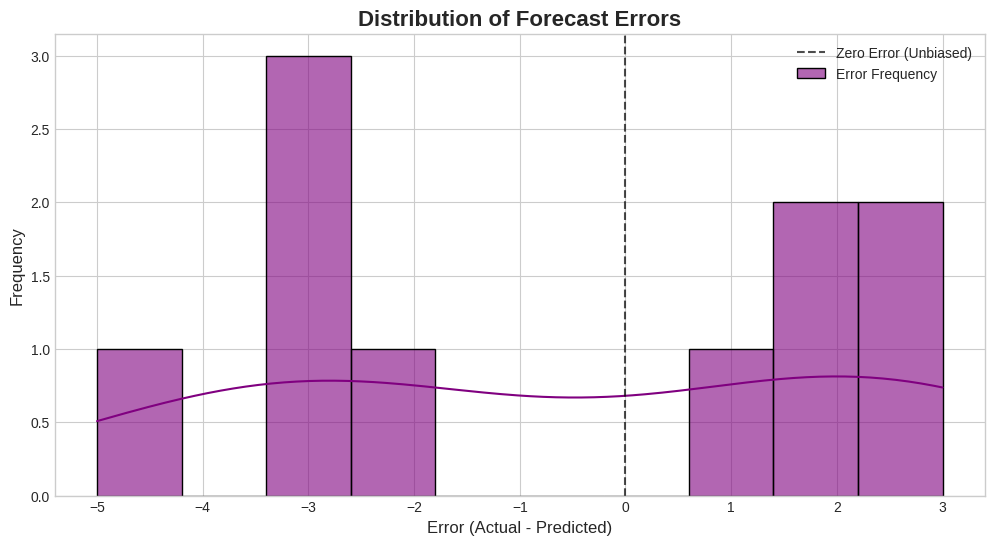

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

sns.histplot(
    errors,
    bins=10,        # Number of bins to create; can be adjusted
    kde=True,       # Adds the smooth Kernel Density Estimate line
    color='purple',
    alpha=0.6,
    label='Error Frequency'
)

# Add a vertical dashed line at zero to represent a perfect (unbiased) forecast
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Zero Error (Unbiased)')

# Add titles and labels for clarity
plt.title('Distribution of Forecast Errors', fontsize=16, fontweight='bold')
plt.xlabel('Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Display the plot
plt.show()

This chart gives a clear view of the error distribution, showing that the model is slightly biased toward over-predicting (the peak is left of zero) but also makes large under-prediction errors.

### Error by Subgroups (e.g., Day of Week, Product Category)

A crucial part of error analysis is to examine how forecast performance varies across different subgroups. By splitting errors by a dimension like "Day of Week," we can uncover hidden patterns, such as a model that performs well on weekdays but poorly on weekends.

#### How to Interpret the Plot
When analyzing a box plot of errors grouped by a category, you are looking for systematic differences between the groups.

*   **Variation in the Median Error:**
    *   Check if the **median line (the center of the box)** is consistently different from zero for any subgroup.
    *   *Example:* If the median error for weekends is positive, it suggests the model systematically **under-predicts** on weekends.

*   **Differences in Error Spread:**
    *   Compare the **size of the boxes (the interquartile range)** across categories.
    *   *Example:* A much larger box for Fridays indicates that the model's performance is more volatile and less reliable on that day.

*   **Presence of Outliers:**
    *   Look for individual points plotted far outside the "whiskers."
    *   *Example:* A cluster of large positive outliers on Mondays could point to a recurring issue the model fails to capture at the start of the week.

In [ ]:
# --- Prepare Data for Analysis and Plotting ---
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

error_df = pd.DataFrame({
    'Error': errors,
    'DayOfWeek': [day_names[i] for i in days_of_week_numeric]
})

# --- Build the Box Plot with Altair ---
# We use mark_boxplot, which handles the single-point-as-a-line case automatically.
error_by_day_plot = alt.Chart(error_df).mark_boxplot(
    size=40,   # Controls the visual width of the boxes
    extent=1.5, # Standard definition for whiskers (1.5 * IQR)
    median=alt.MarkConfig(color='white', strokeWidth=2),
    outliers=True
).encode(
    # To ensure days are sorted chronologically, we provide the 'sort' list.
    x=alt.X('DayOfWeek:O', title='Day of Week', sort=day_names, axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Error:Q', title='Error (Actual - Predicted)', scale=alt.Scale(domain=[-5.5, 3.5])),
    color=alt.Color('DayOfWeek:N',
                    legend=None,
                    scale=alt.Scale(scheme='viridis'))
)

# Add a zero-line for reference to easily spot bias
zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='black', strokeDash=[2,2]).encode(y='y')

# Combine the plots and set final properties
final_plot = (error_by_day_plot + zero_line).properties(
    title='Distribution of Forecast Errors by Day of Week',
    width=800,
    height=400
).configure_title(
    fontSize=18
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

# Display the chart
final_plot

alt.LayerChart(...)

This box plot visualizes the distribution of forecast errors for each day of the week, allowing for a direct comparison of model performance and bias across these subgroups. Days with a single data point, like Thursday through Sunday, are correctly rendered as a simple line, indicating there is no statistical spread to measure.

In [ ]:
# Summary Statistics by Subgroup
# Group by the day of the week and calculate the mean and standard deviation of the errors
error_summary = error_df.groupby('DayOfWeek')['Error'].agg(['mean', 'std']).reindex(day_names)
print("--- Error Summary by Day of FWeek ---")
error_summary.round(2)

--- Error Summary by Day of FWeek ---


,mean,std
DayOfWeek,,
Monday,0.0,4.24
Tuesday,0.0,4.24
Wednesday,-1.0,2.83
Thursday,-2.0,NaN
Friday,2.0,NaN
Saturday,2.0,NaN
Sunday,-5.0,NaN


### Error by Subgroups: Forecast Horizon Errors

This analysis examines how forecast errors vary across different forecast horizons or steps. It's a crucial test to assess how a model's performance degrades as it predicts further into the future.

#### How to Interpret Errors by Forecast Horizon
When analyzing a plot of error metrics broken down by each step into the future, you are looking for how the model's performance changes.

*   **Increasing Error with Horizon (The Expected Pattern):**
    *   You should generally expect the error to **grow** as the forecast horizon increases. It is almost always harder to predict 7 days ahead than 1 day ahead.
    *   *What matters is the **rate** of increase.* A steep increase suggests the model's reliability decays quickly.
*   **Stability or Dips in Error:**
    *   If the error remains stable, the model is consistently reliable.
    *   *Unusual dips* in error at specific steps can sometimes suggest the model has overfit to a pattern that occurs at that particular lag.
*   **Outliers at Specific Horizons:**
    *   Look for a sudden, large spike in error at a specific horizon step. This might indicate a problem with predicting a recurring event at that specific lag (e.g., a weekly effect at step 7).
*   **Bias Trends Across the Horizon:**
    *   Observe if the model shows a systematic bias that changes over the horizon. For example, it might be unbiased for the 1-day forecast but then become progressively more biased as it forecasts further out.

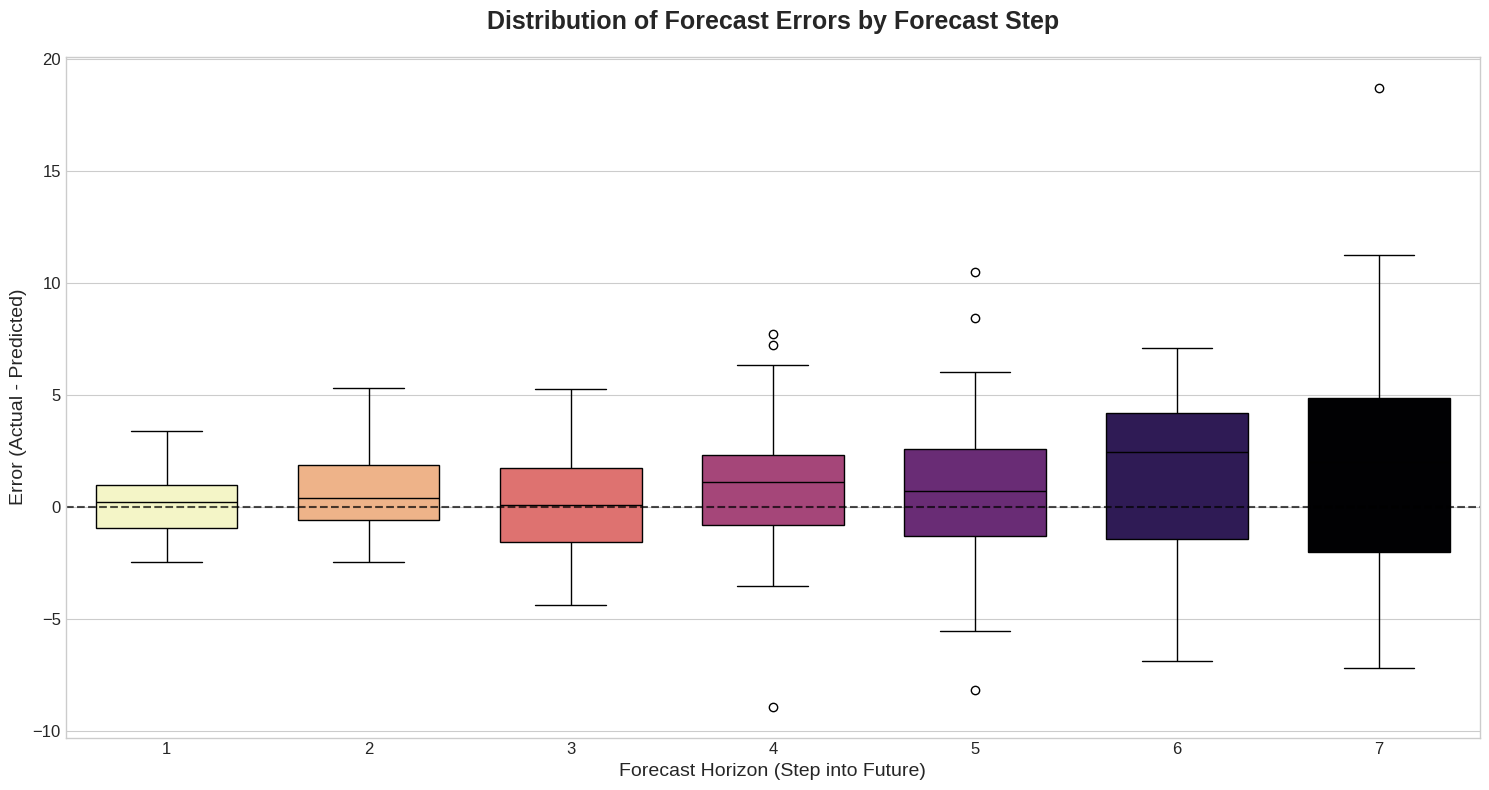

In [ ]:
# We need multiple error values for each forecast step to create meaningful box plots.
# Let's simulate making 50 forecasts, each predicting 7 days into the future.
n_forecasts = 50
horizon = 7
all_errors = []
all_steps = []

np.random.seed(42) # for reproducibility
for _ in range(n_forecasts):
    for step in range(1, horizon + 1):
        # Simulate error increasing as the horizon gets longer
        # The mean (loc) gets slightly more positive, and the spread (scale) increases.
        error = np.random.normal(loc=(step * 0.2), scale=(1 + step * 0.5))
        all_errors.append(error)
        all_steps.append(step)

# Create the DataFrame for analysis
error_by_step_df = pd.DataFrame({
    'Error': all_errors,
    'ForecastStep': all_steps
})

# --- Build the Improved Box Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 8))

sns.boxplot(
    x='ForecastStep',
    y='Error',
    data=error_by_step_df,
    hue='ForecastStep',
    palette='magma_r',
    legend=False,
    width=0.7
)

# Add a zero-line for reference to easily spot bias
plt.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Add titles and labels for clarity
plt.title('Distribution of Forecast Errors by Forecast Step', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Forecast Horizon (Step into Future)', fontsize=14)
plt.ylabel('Error (Actual - Predicted)', fontsize=14)
plt.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

> This box plot visualizes the distribution of forecast errors at each step into the future, clearly showing how the model's accuracy and bias change as the forecast horizon increases.

In [ ]:
# Group by the forecast step and calculate the mean and standard deviation
step_error_summary = error_by_step_df.groupby('ForecastStep')['Error'].agg(['mean', 'std'])
print("--- Error Summary by Forecast Step ---")
step_error_summary.round(2)

--- Error Summary by Forecast Step ---


,mean,std
ForecastStep,,
1,0.07,1.27
2,0.65,1.75
3,0.20,2.37
4,0.97,3.10
5,0.66,3.48
6,1.42,3.62
7,1.86,4.89


### Analysis by Bins of True Values and Errors

To diagnose specific weaknesses, we can analyze how forecast errors vary across different ranges of actual sales quantities and error magnitudes.

*   **Analyzes Performance in Segments:** This method breaks down model performance by **grouping (binning) the data**. This answers the crucial question: *"Does the model perform equally well during low, medium, and high sales periods?"*
*   **Identifies Where and Why the Model Fails:**
    *   **Binning by True Value** reveals if the model's error *changes* under different conditions.
    *   **Binning by Error Magnitude** reveals the *frequency and impact* of major forecast mistakes.
*   **Guides Targeted Model Improvements:** The insights directly inform next steps. If large errors consistently occur *only* in the highest sales bin, it points to a need for features to handle peaks or a different modeling approach.

**Creating the Binned Error Analysis Table**

Instead of separate plots, we'll create a single table (and its heatmap visualization) that shows the **count of instances for each true-value-bin and error-bin combination**. This provides a powerful, at-a-glance summary of model performance across different operating conditions.

In [ ]:
# --- Simulate a More Realistic Dataset ---
# To create a meaningful table, we need more data than our 10-point array.
# Let's simulate 300 data points with specific, designed-in flaws.
np.random.seed(42)
n_points = 300

# True values with a wide range
true_values = np.random.gamma(2, 5, n_points) * 20
# Let's make our model have a flaw: it under-predicts high values more severely
errors = np.random.normal(0, 5, n_points) - (true_values * 0.15)
predicted_values = true_values + errors

# --- Create the DataFrame and Bins ---
error_df = pd.DataFrame({
    'TrueValue': true_values,
    'AbsError': np.abs(errors)
})

# Define bins for the true values
true_bins = [0, 25, 50, float('inf')]
true_labels = ['Low (0-25)', 'Medium (25-50)', 'High (>50)']
error_df['True Value Bin'] = pd.cut(error_df['TrueValue'], bins=true_bins, labels=true_labels, right=False)

# Define bins for the absolute error
error_bins = [0, 5, 15, float('inf')]
error_labels = ['Small (<5)', 'Medium (5-15)', 'Large (>15)']
error_df['Absolute Error Bin'] = pd.cut(error_df['AbsError'], bins=error_bins, labels=error_labels, right=False)

# Drop any rows where binning might have failed (if any values were negative)
error_df.dropna(inplace=True)


# --- Create the Contingency Table using pd.crosstab ---
contingency_table = pd.crosstab(
    index=error_df['True Value Bin'],
    columns=error_df['Absolute Error Bin'],
    dropna=False
)

print("--- Contingency Table of Error Counts ---")
print("This table shows the count of instances for each True-Value and Error-Bin combination.")
contingency_table


--- Contingency Table of Error Counts ---
This table shows the count of instances for each True-Value and Error-Bin combination.


Absolute Error Bin,Small (<5),Medium (5-15),Large (>15)
True Value Bin,,,
Low (0-25),5,1,0
Medium (25-50),6,12,0
High (>50),3,52,221


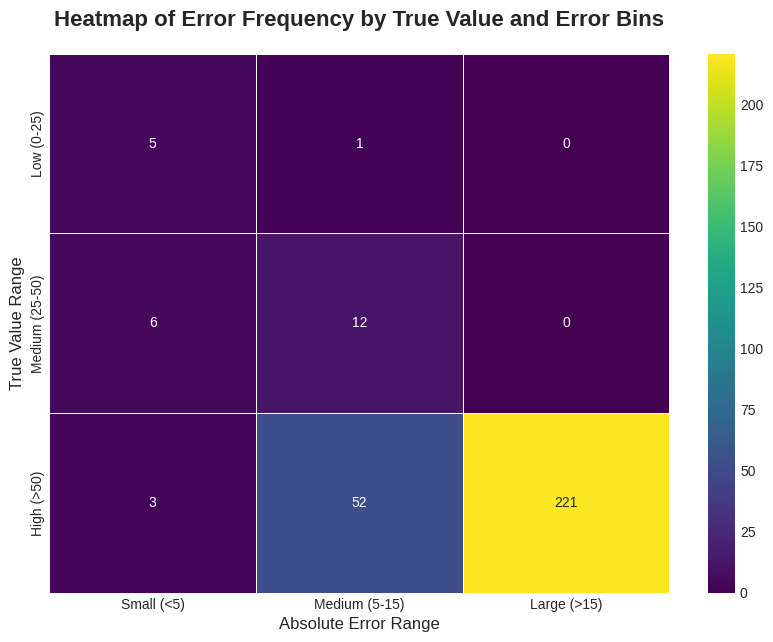

In [ ]:
# --- Visualize the Table with a Heatmap ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 7))

sns.heatmap(
    contingency_table,
    annot=True,     # Display the counts on the cells
    fmt='d',        # Format the numbers as integers
    cmap='viridis', # A nice color map
    linewidths=.5
)

plt.title('Heatmap of Error Frequency by True Value and Error Bins', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Value Range', fontsize=12)
plt.xlabel('Absolute Error Range', fontsize=12)
plt.show()

This heatmap reveals that the model's performance is highly dependent on sales volume, as nearly all of the "Large" errors (errors >15) occur when the "True Value" of sales is high.